### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## Load the data
training_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/test.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


### Eksplorasi Data

In [6]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [7]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


### Data Splitting

In [8]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


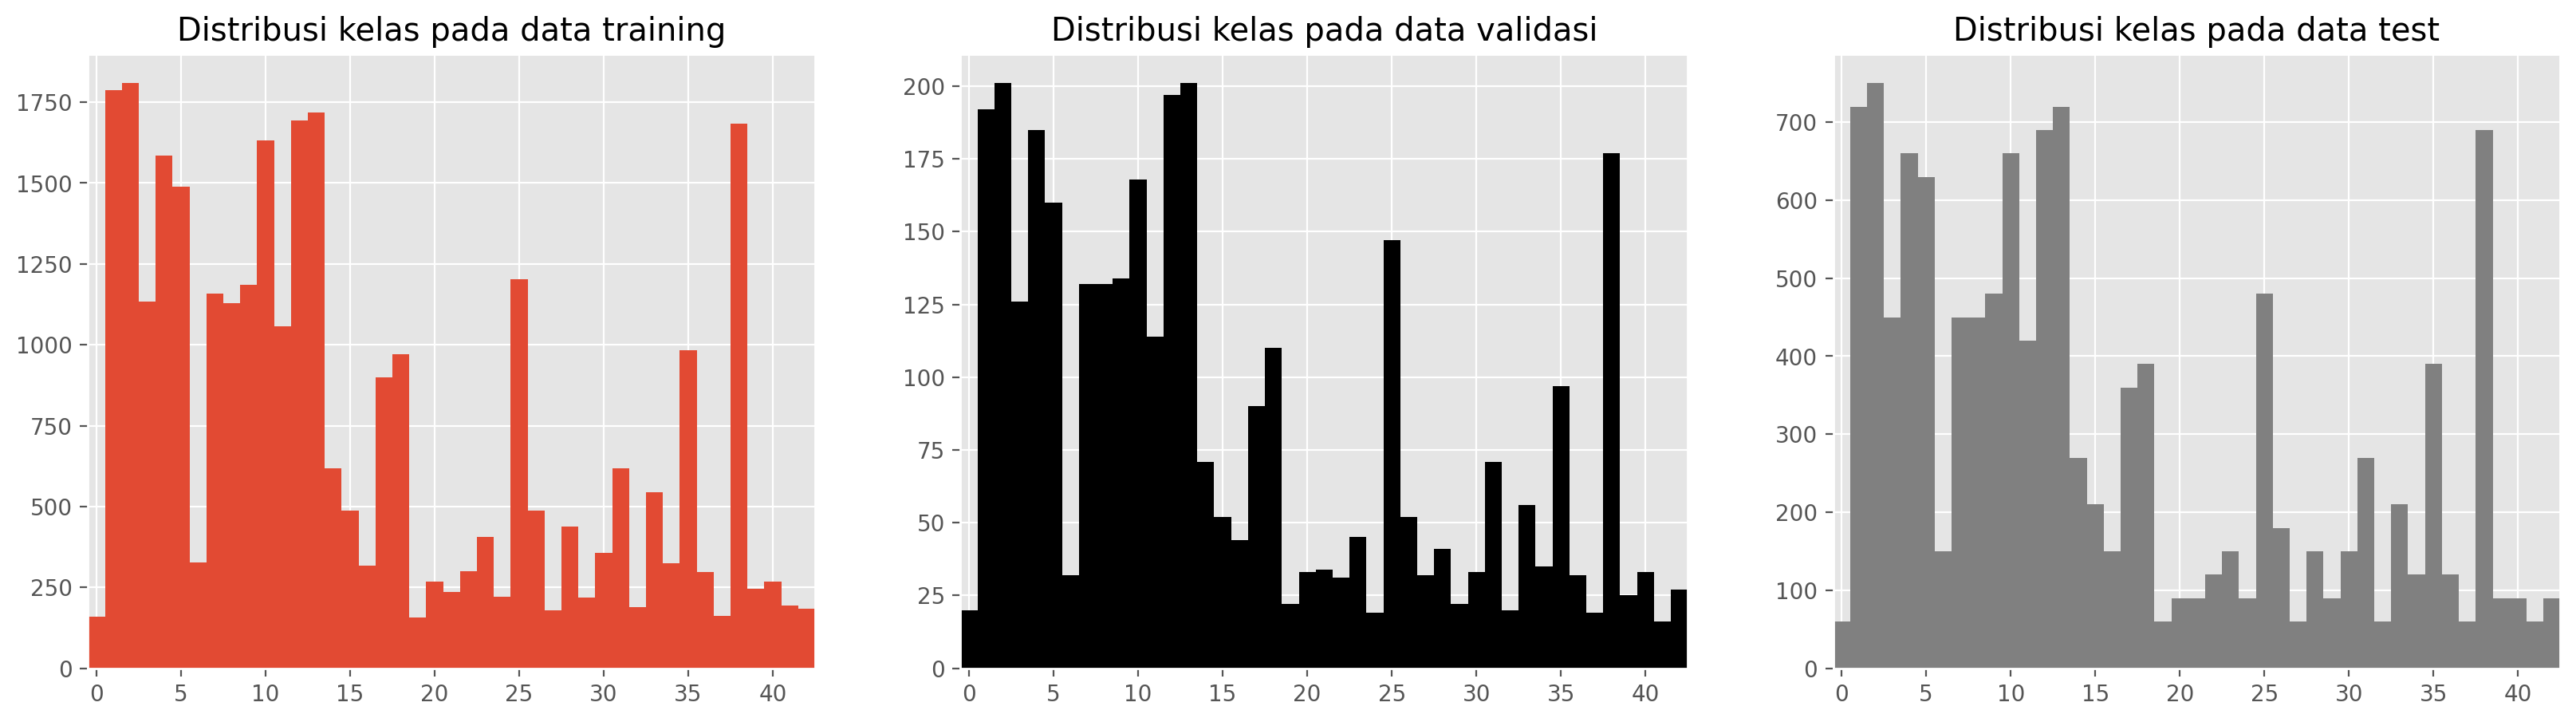

In [9]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

### Label Encoding

In [10]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

### Training dengan CNN

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - accuracy: 0.3649 - loss: 3.0315 - val_accuracy: 0.9003 - val_loss: 0.3697
Epoch 2/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 191s 153ms/step - accuracy: 0.8329 - loss: 0.5777 - val_accuracy: 0.9592 - val_loss: 0.1549
Epoch 3/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 147s 151ms/step - accuracy: 0.8950 - loss: 0.3513 - val_accuracy: 0.9661 - val_loss: 0.1235
Epoch 4/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 202s 151ms/step - accuracy: 0.9149 - loss: 0.2912 - val_accuracy: 0.9727 - val_loss: 0.1096
Epoch 5/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 201s 150ms/step - accuracy: 0.9254 - loss: 0.2624 - val_accuracy: 0.9830 - val_loss: 0.0714
Epoch 6/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 203s 151ms/step - accuracy: 0.9336 - loss: 0.2325 - val_accuracy: 0.9773 - val_loss: 0.0842
Epoch 7/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 200s 149ms/step - accuracy: 0.9379 - loss: 0.2161 - val_accuracy: 0.9670 - val_loss: 0.1178
Epoch 8/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 203s 151ms/step - accuracy: 0.9381 -

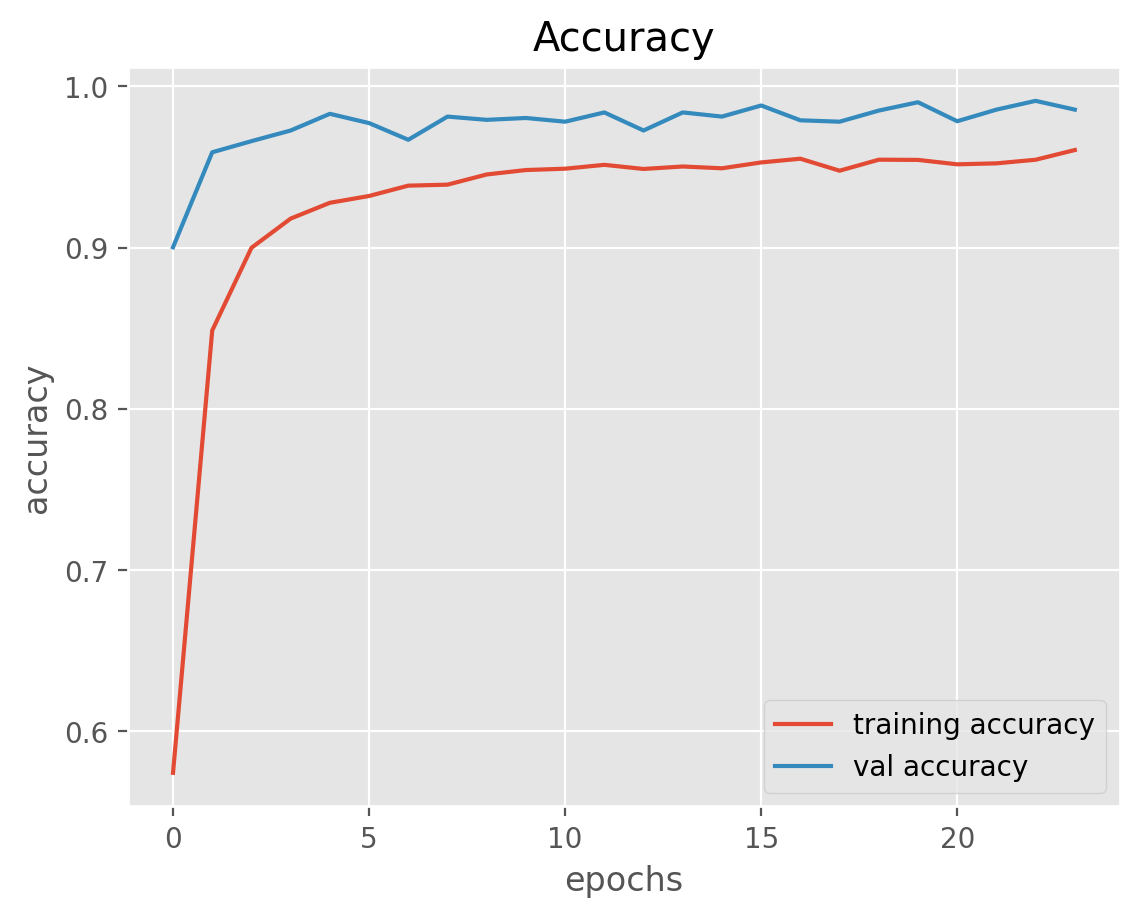

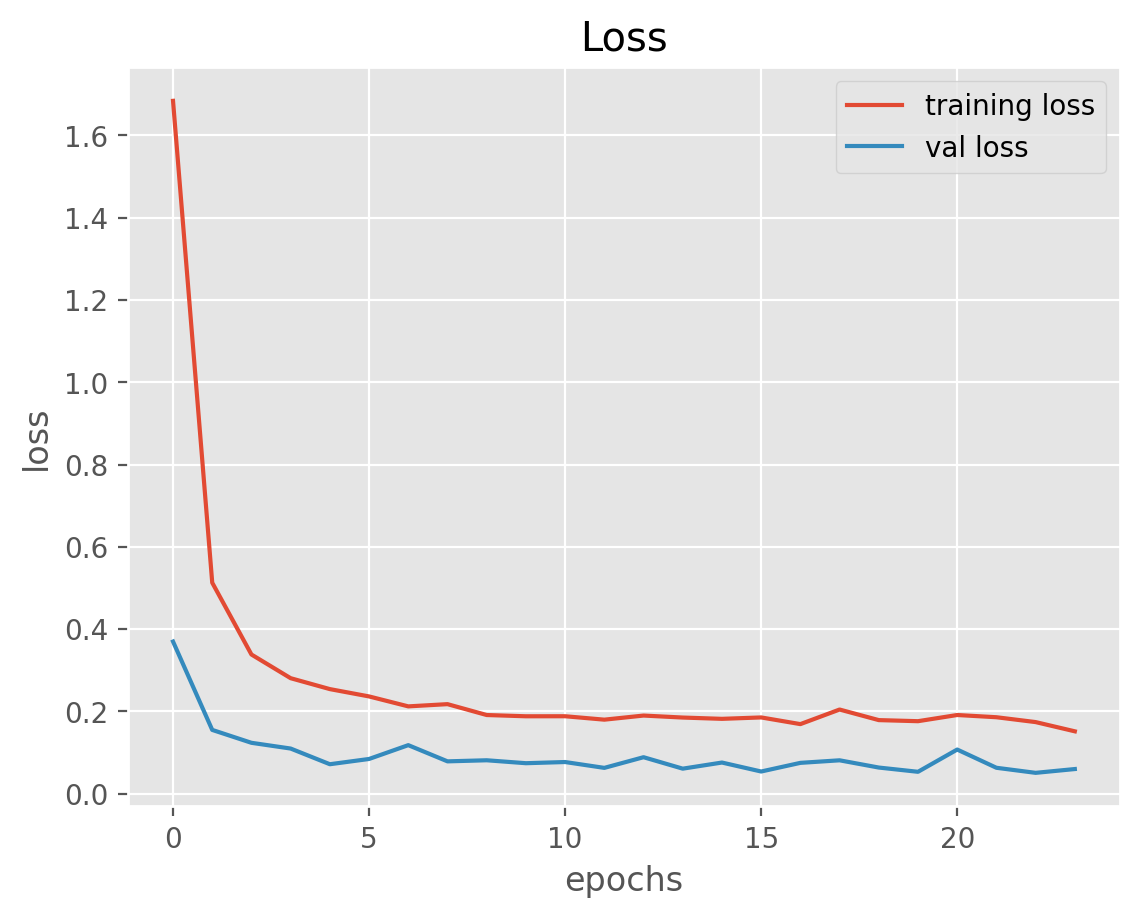

In [17]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Testing

In [18]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step


0.9391923990498813

In [19]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.97      0.95      0.96       720
           2       0.94      0.98      0.96       750
           3       0.89      0.93      0.91       450
           4       0.92      0.98      0.95       660
           5       0.90      0.90      0.90       630
           6       0.99      0.81      0.89       150
           7       0.97      0.91      0.94       450
           8       0.90      0.95      0.92       450
           9       0.98      1.00      0.99       480
          10       1.00      0.98      0.99       660
          11       0.93      0.94      0.93       420
          12       0.97      0.95      0.96       690
          13       0.97      0.97      0.97       720
          14       0.98      1.00      0.99       270
          15       0.80      1.00      0.89       210
          16       0.99      1.00      1.00       150
          17       1.00    